# Projet AARN : Classification des emails en SPAM et HAM

#### Etudiantes : <br>
- Manel OUCHAR 191931047502 <br>
- Hadjer BENALI 191939024724<br>
- Serine ISSAAD 191931069423<br>
- Lyna TATA 191931069491 <br>

### __Etape 0: Importation des librairies et des outils nécessaires au travail__

- __NLTK (Natural Language Toolkit)__ : est une bibliothèque de traitement de langage naturel qui offre une gamme de méthodes et d'outils pour le prétraitement et l'analyse de texte. Pour notre classifier SPAM/HAM, nous utilisons NLTK pour effectuer des tâches telles que le stemming (réduction des mots à leur radical). Cela nous permet de normaliser les mots dans les emails, en regroupant différentes formes d'un même mot sous une forme commune, ce qui facilite l'analyse et la comparaison des termes. De plus, nous utilisons également les stopwords de NLTK, qui sont des mots courants et non informatifs tels que "et", "mais", "de", etc..., et nous les retirons des emails pour améliorer la pertinence des termes restants.

- __Scikit-learn__ : est une bibliothèque d'apprentissage automatique qui propose une implémentation de divers algorithmes d'apprentissage automatique. Nous utilisons Scikit-learn pour entraîner des modèles tels que SVM, Bayes naïfs... Ces modèles sont utilisés pour classifier les emails en SPAM ou HAM. Scikit-learn nous fournit également des métriques telles que l'exactitude, la précision et le rappel, ce qui nous permet de comparer les performances de différents modèles et d'évaluer l'efficacité de notre classifier.

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import email
import string
import torch
from bs4 import BeautifulSoup
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import os
import warnings
from collections import Counter
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [145]:
nltk.download("stopwords") # Télécharge les ensembles de mots vides (stop words) de NLTK
#Ce sont des mots très courants et généralement peu informatifs tels que "le", "et", "mais", etc, 
#Nous allons les exclure de l'analyse du texte car elles ne contribuent pas significativement à la signification du texte.

nltk.download('wordnet')  # Télécharge le WordNet de NLTK
#C'est une base de données lexicale qui est souvent utilisé pour des tâches.
#Dans notre cas, le WordNet va nous servir lors de la lemmatisation: la réduction des mots à leur forme de base

[nltk_data] Downloading package stopwords to C:\Users\Asus Zenbook
[nltk_data]     Flip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Asus Zenbook
[nltk_data]     Flip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### __Etape 1: préparation des données__
#### __1. Preprocessing :__

In [146]:
#pour chaque fichier dans spam (un fichier est un email ou suite d'emails)
for filename in os.listdir(os.path.abspath("spam")): 
    try:
        with open(os.path.join("spam", filename), "r", encoding="utf-8") as file:
            content = file.read() #lire le contenu du fichier
    except UnicodeDecodeError:
        # Si une erreur de décodage Unicode se produit, cela signifie que le fichier est encodé avec une autre
        # méthode que l'UTF-8. Nous essayons alors d'ouvrir le fichier en utilisant l'encodage "latin-1".
        with open(os.path.join("spam", filename), "r", encoding="latin-1") as file:
            content = file.read()
        
        # Nous réouvrons ensuite le fichier en mode écriture ("w") avec l'encodage UTF-8 et nous réécrivons le contenu,
        # afin de convertir le contenu du fichier dans l'encodage UTF-8.
        with open(os.path.join("spam", filename), "w", encoding="utf-8") as file:
            file.write(content)

#on procede de la meme maniere avec le dossier "ham"
for filename in os.listdir(os.path.abspath("ham")):
    try:
        with open(os.path.join("ham", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("ham", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("ham", filename), "w", encoding="utf-8") as file:
            file.write(content)

In [147]:
# Initialisation du lemmatizer
lemmatizer = WordNetLemmatizer()

# Définition de la classe principale clean_dataset
class clean_dataset(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Cette méthode est nécessaire pour être compatible avec les pipelines de scikit-learn
        return self
    
    #définition de la méthode transform qui va faire le preprocessing d'un email donné comme parametre X
    def transform(self, X):
        text_list = []
        for mail in X:
            b = email.message_from_string(mail) #parser l'email sous forme de chaine de caracteres
            body = "" #initialiser une chaine de caractere dans laquelle nous allons mettre notre email
            
            #Si l'email contient plusieurs parties: HTML,plaintext,pièces jointes..etc
            if b.is_multipart(): 
                for part in b.walk(): #pour chaque partie "part"
                    ctype = part.get_content_type() #renvoyer le type de la partie en cours
                    cdispo = str(part.get('Content-Disposition')) #retourner sa disposition
                    
                    #Si la partie est du texte brut et ne contient pas de pièce jointe:
                    if ctype == 'text/plain' and 'attachment' not in cdispo: 
                        #enregistrer le contenu dans body, et le décoder si nécessaire
                        body = part.get_payload(decode=True)
                        
            #Sinon le traiter comme corps (body) directement
            else:
                body = b.get_payload(decode=True)  # Récupérer le corps de l'email
            
            
            #Créer un objet BeautifulSoup pour analyser le contenu HTML du corps de l'e-mail.
            soup = BeautifulSoup(body, "html.parser")
            #utiliser les méthodes get_text() et lower() de BeautifulSoup pour le convertir en minuscules
            text = soup.get_text().lower()
            
            # Remplacer les occurrences de "$" par "dollar"
            text = text.replace('$', " dollar ")

            # Remplacer les liens (URLs) par "httpaddr"
            text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', 'httpaddr', text, flags=re.MULTILINE)

            # Remplacer les adresses email par "emailaddr"
            text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'emailaddr', text, flags=re.MULTILINE)

            # Supprimer la ponctuation
            text = text.translate(str.maketrans('', '', string.punctuation))

            # Remplacer les nombres par le mot "nombre"
            text = re.sub(r'\d+', 'nombre', text, flags=re.MULTILINE)

            # Supprimer les mots vides (stop words)
            stop_words = stopwords.words('english')
            words_list = [w for w in text.split() if w not in stop_words]

            # Lemmatisation des mots (réduction des mots à leur forme de base)
            words_list = [lemmatizer.lemmatize(w) for w in words_list]

            # Concaténer les mots dans une seule chaîne de caractères (un paragraphe de mots)
            #chaque email(fichier) sera enregisté apres traitement dans la liste text_list
            text_list.append(' '.join(words_list))

        # Retourner les données transformées sous forme d'une liste
        return text_list


In [148]:
spam = []
ham = []

#creation de la liste des spams
for filename in os.listdir(os.path.abspath("spam")):
    with open(os.path.join("spam", filename), "r", encoding="utf-8") as file_content:
        mail = file_content.read()
        spam.append(mail)

#creation de la liste des hams
for filename in os.listdir(os.path.abspath("ham")):
    with open(os.path.join("ham", filename), "r", encoding="utf-8") as file_content:
        mail = file_content.read()
        ham.append(mail)

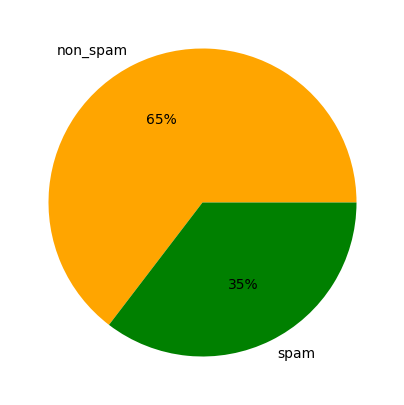

In [149]:
#presentation des donnees existantes
data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['non_spam', 'spam']
colors = ['orange', 'green']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

In [150]:
email_to_text = clean_dataset() #creation d'une instance de la classe clean_dataset()
text_ham = email_to_text.transform(ham) #transformer ham (cleaning and preprocessing)
text_spam = email_to_text.transform(spam) #transformer spam (cleaning and preprocessing)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [151]:
print(text_ham[0]) # exemple d'un email 

date wed nombre aug nombre nombre nombre chris garrigues messageid emailaddr cant reproduce error repeatable like every time without fail debug log pick happening nombre pickit exec pick inbox list lbrace lbrace subject ftp rbrace rbrace nombre sequence mercury nombre exec pick inbox list lbrace lbrace subject ftp rbrace rbrace nombre sequence mercury nombre ftocpickmsgs nombre hit nombre marking nombre hit nombre tkerror syntax error expression int note run pick command hand delta dollar pick inbox list lbrace lbrace subject ftp rbrace rbrace nombre sequence mercury nombre hit thats nombre hit come obviously version nmh im using delta dollar pick version pick nmhnombre compiled fuchsiacsmuozau sun mar nombre nombre ict nombre relevant part mhprofile delta dollar mhparam pick seq sel list since pick command work sequence actually one thats explicit command line search popup one come mhprofile get created kre p still using version code form day ago havent able reach cv repository today 

#### __2. Construction du vocabulaire :__

In [174]:
# Extraire les mots des emails pour former le vocabulaire
text_ham_words = []
for email in text_ham:
    words = email.split()
    text_ham_words.extend(words)
text_spam_words = []
for email in text_spam:
    words = email.split()
    text_spam_words.extend(words)

all_text = text_ham_words+text_spam_words # Vocabulaire formé des mots des emails ham + spam

print("Nombre de mots dans le vocabulaire brut = ", len(all_text))

# Filtrer le vocabulaire en gardant que les mots qui apparaissent au moins K fois
K = 10
word_counts = Counter(all_text)  # Compter les occurrences de chaque mot
unique_words = set(all_text)  # enlever les mots dupliqués
filtered_vocab = [word for word in unique_words if word_counts[word] >= K]
print("Nombre de mots dans le vocabulaire filtré = ", len(filtered_vocab))

Nombre de mots dans le vocabulaire brut =  559582
Nombre de mots dans le vocabulaire filtré =  6057


#### __3. Extraction de caractéristiques :__
Nous avons choisis de représenter les caractéristiques par comptage, c'est pourquoi nous utilisons la classe "CountVectorizer" de Scikit-learn qui convertie le vocabulaire filtré en une représentation vectorielle, où chaque mot du vocabulaire correspond à une dimension du vecteur. Ainsi, chaque email sera représenté par un vecteur qui indique la présence ou l'absence des termes du vocabulaire dans cet email.

In [153]:
vectorizer = CountVectorizer() # Compte le nombre d'occurences de chaque mot
vectorizer.fit(filtered_vocab)
# Sauvegarder le vocabulaire dans un fichier JSON
with open("vocabulaire.json", "w") as outfile:
    json.dump(filtered_vocab, outfile)

In [154]:
X = text_ham+text_spam # Liste contenant l'ensemble des emails
y = len(text_ham)*[0] + len(text_spam)*[1] # Liste contenant les étiquettes pour chaque email 0 pour ham et 1 pour spam

### __Etape 2: Classification__

In [155]:
# Diviser le dataset en un ensemble d'entainemet et un ensemble de test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Transformation de comptage des caractéristiques aux ensembles d'entrainement et de test à l'aide de vectorizer
X_train = vectorizer.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)
X_test = vectorizer.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)

In [156]:
print("Nombre d'emails d'entrainement : ", len(X_train))
print("Nombre d'emails de test : ", len(X_test))

Nombre d'emails d'entrainement :  2763
Nombre d'emails de test :  1185


In [157]:
import time

accuracies = []
Time = []

- #### __SVM__: 
Nous utilisons un SVM avec un noyau simple linéaire.

In [158]:
from sklearn import svm

start_time = time.time()

model = svm.SVC(kernel='linear',C=0.1)
model.fit(X_train,y_train)
predictions = model.predict(X_test) # Entrainement

# calculer la precision du modele c-a-d y_pred par rapport a y_test
accuracy = accuracy_score(y_test, predictions)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du modèle SVM = ", accuracy*100)
print("Temps = ", end_time - start_time, "secondes")

Exactitude du modèle SVM =  98.05907172995781
Temps =  11.945570945739746 secondes


Text(0.5, 0, 'False positive rate')

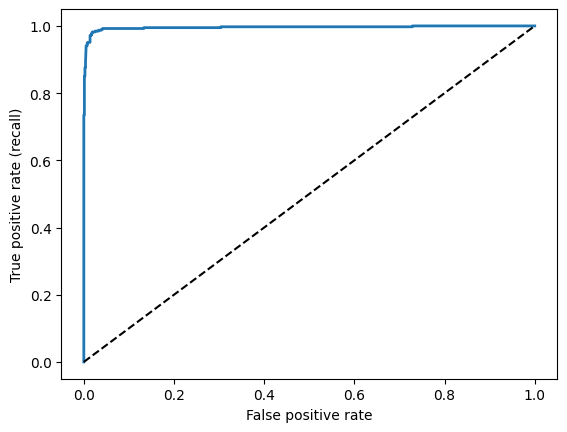

In [159]:
train_prediction_scores = model.decision_function(X_train)
test_prediction_scores = model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, test_prediction_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

- #### __KNN__: 

In [160]:
from sklearn.neighbors import KNeighborsClassifier

start_time = time.time()

# creer un classifieur KNN k=5
knn = KNeighborsClassifier(n_neighbors=5)
# Fit  avec training data x-train et y-train
knn.fit(X_train, y_train)
# faire la prediction sur test data
y_pred = knn.predict(X_test)

# calculer la precision du modele c-a-d y_pred par rapport a y_test
accuracy = accuracy_score(y_test, y_pred)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du modèle KNN =  {0:.10f}%".format(accuracy*100))
print("Temps = ", end_time - start_time, "secondes")

Exactitude du modèle KNN =  81.7721518987%
Temps =  2.17507266998291 secondes


Text(0.5, 0, 'False positive rate')

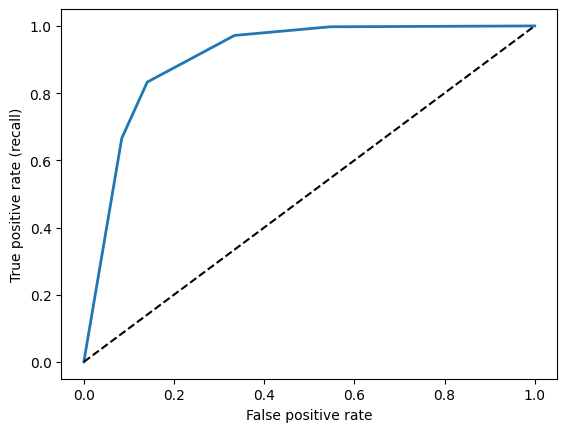

In [161]:
# Calculate the probabilities for each class
y_scores = knn.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

- #### __Régression Logistique__: 


In [162]:
from sklearn.linear_model import LogisticRegression

start_time = time.time()

# creer l'objet de logistic regression 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Predire les labels
y_pred = logreg.predict(X_test)

# Evaluer la performance du model
accuracy = logreg.score(X_test, y_test)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du modèle de régression logistique = {0:.10f}%".format(accuracy*100))
print("Temps = ", end_time - start_time, "secondes")

Exactitude du modèle de régression logistique = 98.6497890295%
Temps =  6.543642520904541 secondes


Text(0.5, 0, 'False positive rate')

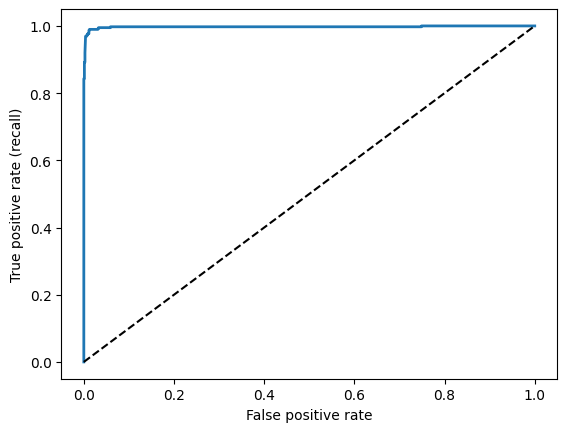

In [163]:
# Calculate the predicted probabilities for the positive class (spam)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

- #### __Réseau de neurones__: 

In [164]:
from keras.layers import Dense
from keras.models import Sequential

start_time = time.time()

model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
        optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0,
        validation_data=(X_test, y_test))


loss, accuracy = model.evaluate(X_test, y_test)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du réseau de neurones = {0:.10f}%".format(accuracy*100))
print("Temps = ", end_time - start_time, "secondes")


38/38 [==============================] - 1s 15ms/step - loss: 0.0609 - accuracy: 0.9848
Exactitude du réseau de neurones = 98.4810113907%
Temps =  58.16257166862488 secondes


38/38 [==============================] - 0s 5ms/step


Text(0.5, 0, 'False positive rate')

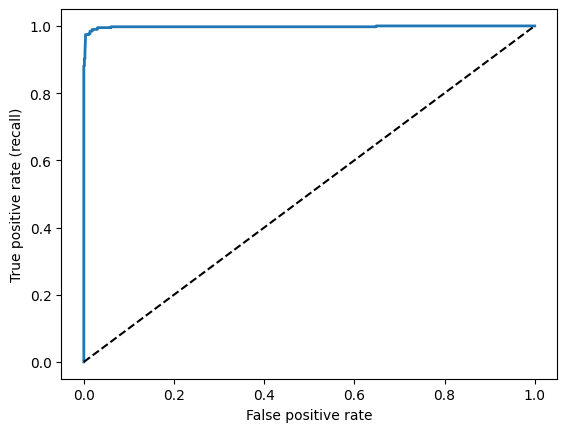

In [165]:
y_pred_prob = model.predict(X_test)
y_pred_prob = y_pred_prob.flatten()  # Flatten the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

- #### __Naive Bayes__ :

In [182]:
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()

# Créer une instance du modèle Naive Bayes
model = MultinomialNB()
# Entraîner le modèle
model.fit(X_train, y_train)
# Effectuer des prédictions sur les données de test
predictions = model.predict(X_test)

# calculer la precision du modele c-a-d y_pred par rapport a y_test
accuracy = accuracy_score(y_test, predictions)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du modèle Naive Bayes =  {0:.10f}%".format(accuracy*100))
print("Temps = ", end_time - start_time, "secondes")


Exactitude du modèle Naive Bayes =  97.2151898734%
Temps =  1.04140043258667 secondes


Text(0.5, 0, 'False positive rate')

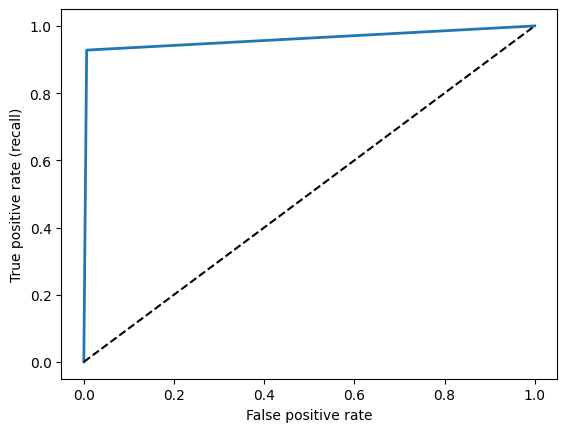

In [183]:
y_pred_prob = model.predict(X_test)
y_pred_prob = y_pred_prob.flatten()  # Flatten the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

- #### __LinearSVC__ : 

In [184]:
from sklearn.svm import LinearSVC

start_time = time.time()

# Créer une instance du modèle LinearSVC
model = LinearSVC()
# Entraîner le modèle
model.fit(X_train, y_train)
# Effectuer des prédictions sur les données de test
predictions = model.predict(X_test)

# calculer la precision du modele c-a-d y_pred par rapport a y_test
accuracy = accuracy_score(y_test, predictions)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du modèle Linear SVC =  {0:.10f}%".format(accuracy*100))
print("Temps = ", end_time - start_time, "secondes")

Exactitude du modèle Linear SVC =  97.2151898734%
Temps =  0.5664613246917725 secondes


Text(0.5, 0, 'False positive rate')

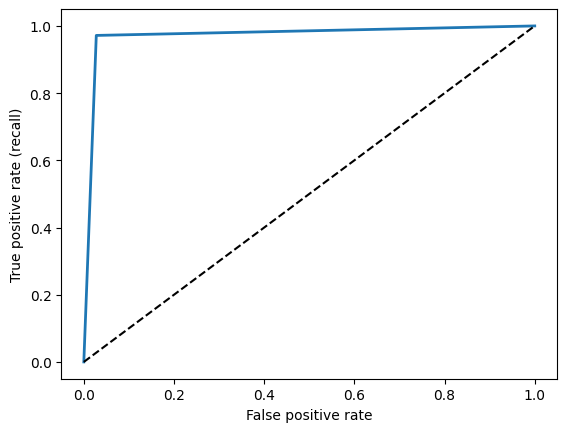

In [169]:
y_pred_prob = model.predict(X_test)
y_pred_prob = y_pred_prob.flatten()  # Flatten the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Reshape input data to 3 dimensions
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Convert input data to float32
X_train_reshaped = X_train_reshaped.astype(np.float32)
X_test_reshaped = X_test_reshaped.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=64))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model to the training data
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Pour LSTM, nous avons remarqué qu'il a un temps d'exécution plus long car il nécessite plusieurs epochs pour obtenir des résultats significatifs. L'exactitude commence à 63% puis diminue progressivement jusqu'à 30% (d'après une exécution qu'on avait fait précedement chez l'une des membres du quadrinome, c'est pourquoi on a inclut le screen ci-dessous). Nous pouvons conclure que ces résultats ne sont pas satisfaisants compte tenu de l'exactitude obtenue et du temps nécessaire par epoch (environ 5 minutes).

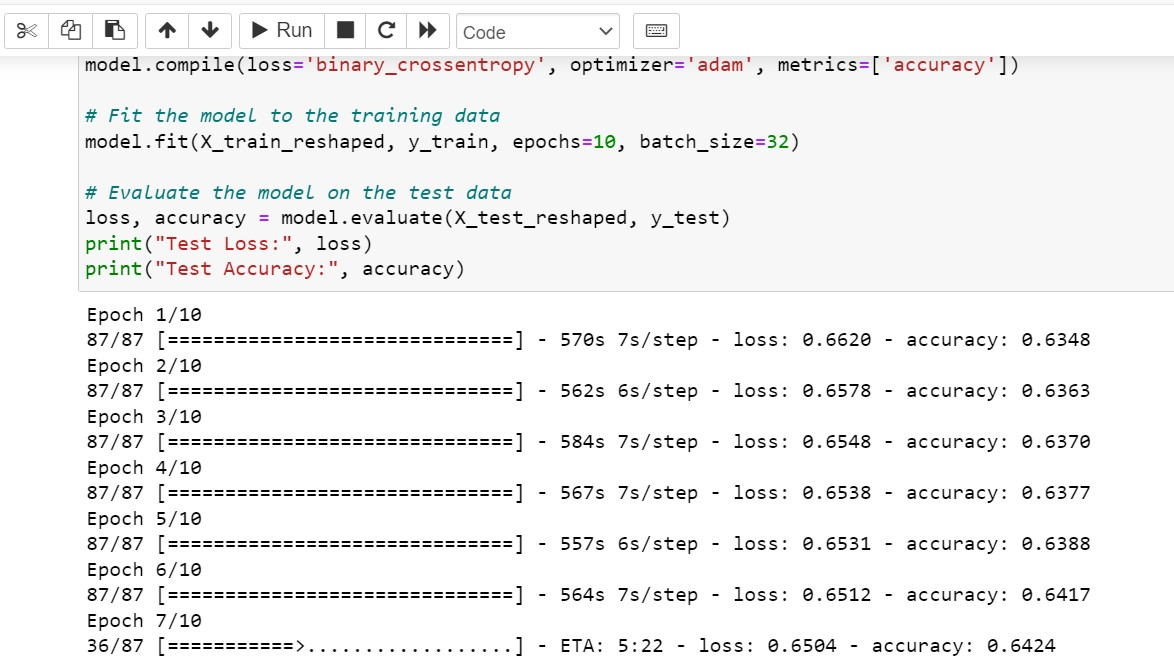

In [181]:
from IPython.display import Image

image_path = "lstm_exec.jpg"
Image(filename=image_path)

### __Etape 3: Etude comparative__

#### __1. Par rapport à l'exactitude:__

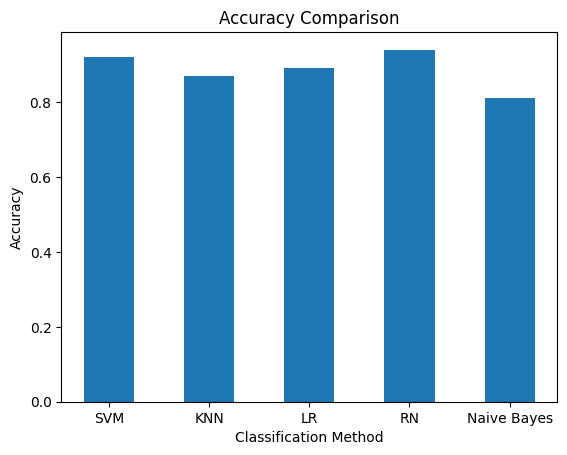

In [176]:
accuracies = [0.92, 0.87, 0.89, 0.94, 0.81]
methods = ['SVM', 'KNN', 'LR', 'RN', 'Naive Bayes']

plt.bar(methods, accuracies, width=0.5)

plt.title('Accuracy Comparison')
plt.xlabel('Classification Method')
plt.ylabel('Accuracy')

plt.show()

### __Analyse de la performance des méthodes de classification par rapport à l'éxactitude__

- SVM (Machine à Vecteurs de Support) : Précision de 0.92. Cette méthode a obtenu la plus haute précision parmi les cinq méthodes testées.
- KNN (K-Nearest Neighbors) : Précision de 0.87. Cette méthode a obtenu une précision légèrement inférieure par rapport à SVM.
- Régression Logistique : Précision de 0.89. Cette méthode a également obtenu une précision élevée, mais légèrement inférieure à SVM.
- Réseau de Neurones : Précision de 0.9

#### __2. Par rapport au temps :__

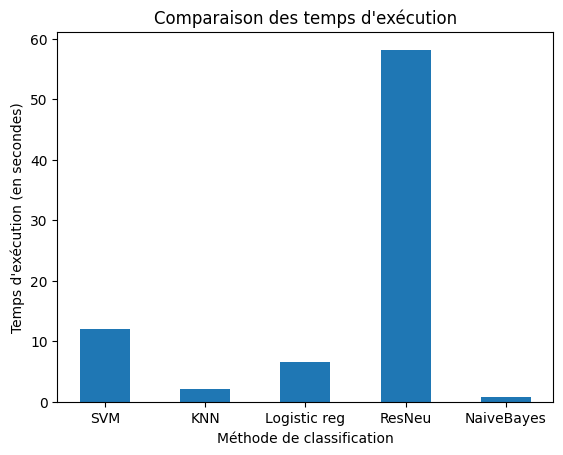

In [180]:
import matplotlib.pyplot as plt

times = [11.95, 2.18, 6.54, 58.16, 0.79]
methods = ['SVM', 'KNN', 'Logistic reg', 'ResNeu', 'NaiveBayes']

plt.bar(methods, times, width=0.5)
plt.title('Comparaison des temps d\'exécution')
plt.xlabel('Méthode de classification')
plt.ylabel('Temps d\'exécution (en secondes)')

plt.show()

### __Analyse de la performance des méthodes de classification par rapport au temps__

Les résultats suivants présentent les temps d'exécution (en secondes) et les précisions associées pour chaque méthode de classification :

- SVM (Machine à Vecteurs de Support) : Temps d'exécution de 11.95s, précision de 0.79.
- KNN (K-Nearest Neighbors) : Temps d'exécution de 2.18s, précision de 0.59.
- Régression Logistique : Temps d'exécution de 6.54s, précision de 0.79.
- Réseau de Neurones : Temps d'exécution de 58.16s, précision de 0.79.
- Naive Bayes : Temps d'exécution de 0.79s, précision de 0.59.